In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

# Pulse Builder (with alignment!!) Project

## Team:

Soolu,
Thomas,
George,
Blake,
Will,
Frank

In [3]:
# some imports
from qiskit import pulse
from qiskit.pulse import Schedule, DriveChannel, MeasureChannel, AcquireChannel
from qiskit.pulse.context import build, measure, u1, u2, cx, x, delay, play, shift_phase, \
    left_align, left_barrier, right_align, right_barrier, sequence, align_center, sprinkle

from math import pi
from qiskit.pulse.pulse_lib.discrete import gaussian

from qiskit.test.mock import FakeAlmaden

backend = FakeAlmaden()

channels_to_plot = [DriveChannel(0), DriveChannel(1), MeasureChannel(0), MeasureChannel(1)]


In [40]:
# basic example with left_barrier()

schedule = Schedule()
with build(backend, schedule):
    u2(0, 0, pi/2)
    delay(0, 1000)
    u2(0, 0, pi)
    with left_barrier():
        play(DriveChannel(0), gaussian(500, 0.1, 125))
        shift_phase(DriveChannel(0), pi/2)
        play(DriveChannel(0), gaussian(500, 0.1, 125))
        u2(1, 0, pi/2)
    u2(1, 0, pi/2)

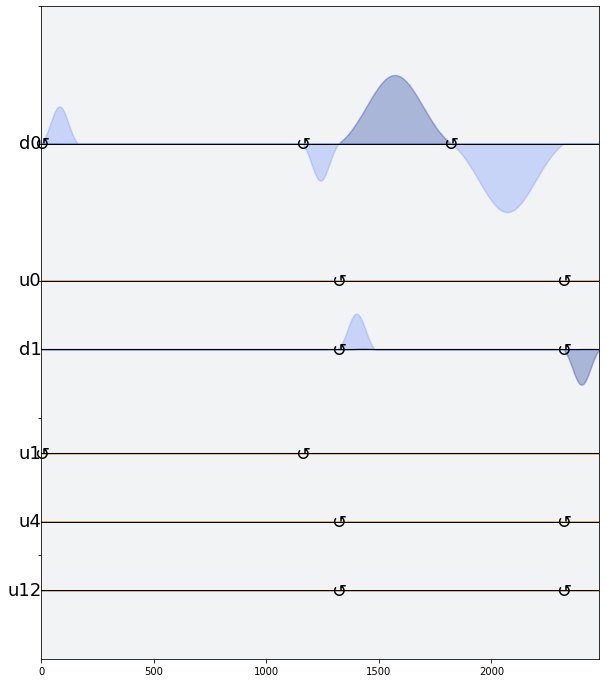

In [41]:
schedule.draw(table=False)

In [45]:
# basic example with left_align()

schedule = Schedule()
with build(backend, schedule):
    u2(0, 0, pi/2)
    delay(0, 1000)
    u2(0, 0, pi)
    with left_align():
        play(DriveChannel(0), gaussian(500, 0.1, 125))
        shift_phase(DriveChannel(0), pi/2)
        play(DriveChannel(0), gaussian(500, 0.1, 125))

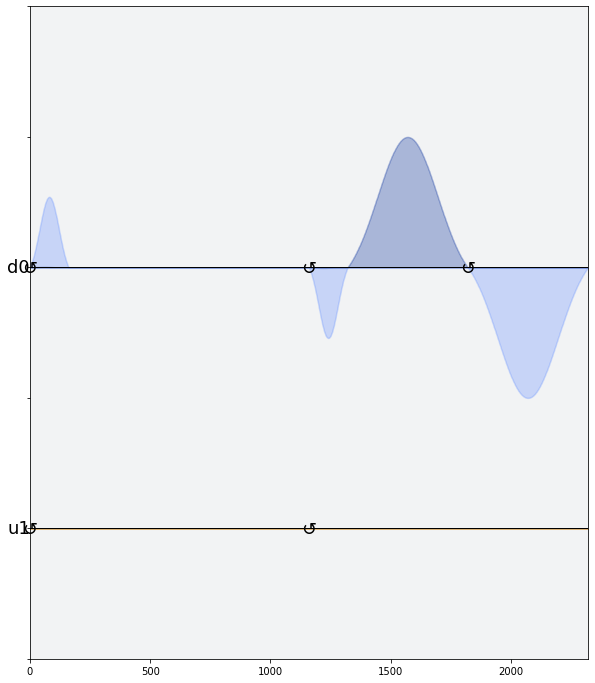

In [46]:
schedule.draw(table=False)

In [43]:
# sequential instructions (implied barriers between each pulse)

schedule = Schedule()
with build(backend, schedule):
    with sequence():
        u2(0, 0, pi/2)
        u2(1, 0, pi/2)
        u2(0, 0, pi/2)
        u2(1, 0, pi/2)

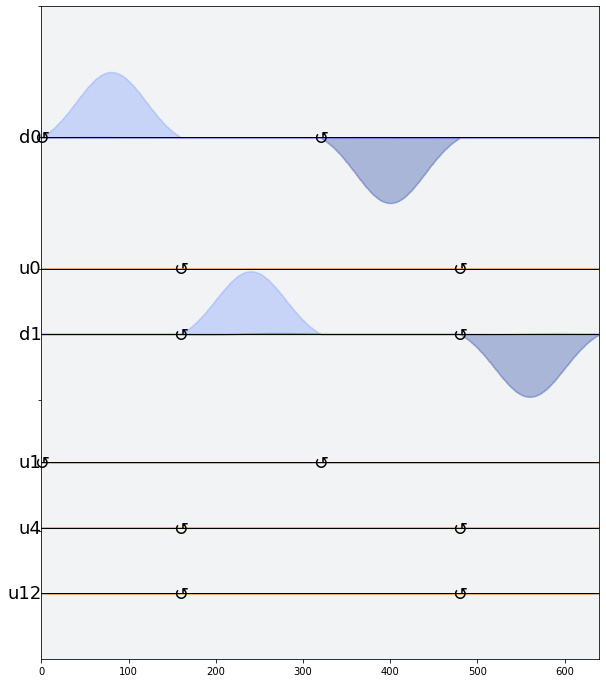

In [37]:
schedule.draw(table=False)

In [5]:
from qiskit.pulse.commands import PulseInstruction

schedule = Schedule()
with build(backend, schedule):
    u2(0, 0, 0)

y90p_instruction = schedule.filter(instruction_types=[PulseInstruction])
y90p = y90p_instruction.instructions[0][1].command

In [77]:
# Hahn echo with align_center()

tau = 1000
schedule = Schedule()
with build(backend, schedule):
    u2(0, 0, pi)
    with align_center():
        delay(0, tau)
        x(0)
    u2(0, 0, pi)

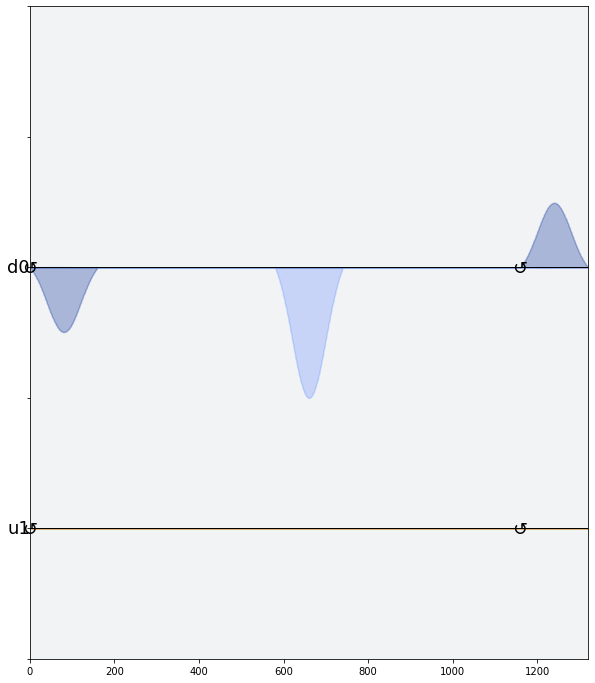

In [78]:
schedule.draw(table=False)

In [14]:
# Let's run it on a real device. Usual setup for that...

from qiskit import IBMQ
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default') 
real_backend = provider.get_backend("ibmq_armonk")

In [39]:
def hahn_echo(qubit, tau, backend):
    schedule = Schedule()
    with build(backend, schedule):
        u2(qubit, 0, pi)
        with align_center():
            delay(qubit, tau)
            x(qubit)
        u2(qubit, 0, pi)
        with left_barrier():
            measure(qubit)
            delay(qubit, 0)
    return schedule

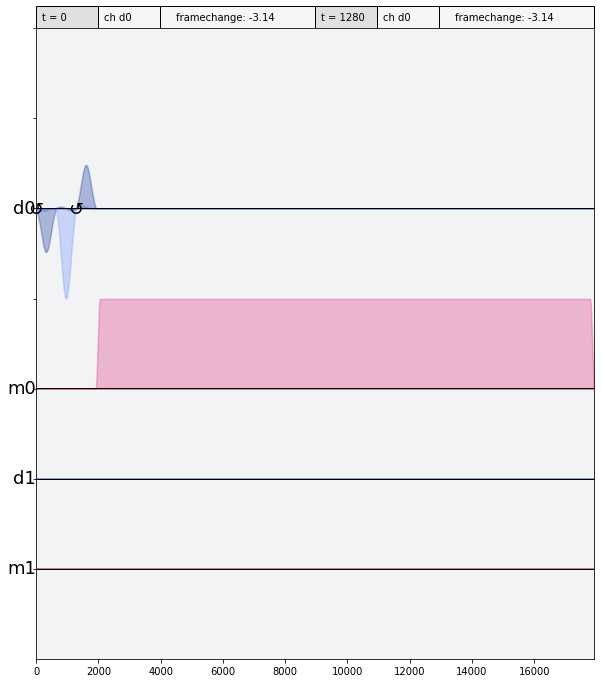

In [40]:
hahn_echo(0, 100, real_backend).draw(channels_to_plot=channels_to_plot)

In [67]:
dts = range(0, 400000, 20000)
experiments = [hahn_echo(0, tau, real_backend) for tau in dts]

In [79]:
4000000 * 0.23

920000.0

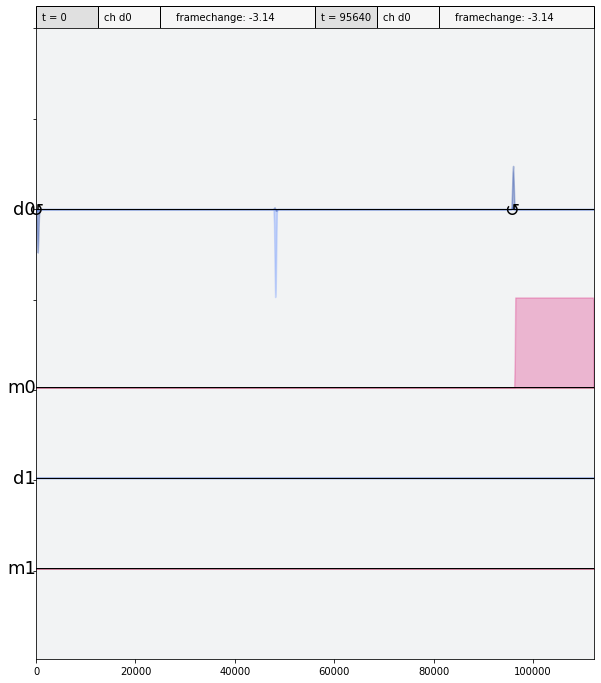

In [42]:
experiments[19].draw(channels_to_plot=channels_to_plot)

In [68]:
# actually run it

from qiskit import execute

job = execute(experiments, real_backend, meas_level=2, shots=512)

result = job.result()
data = [result.get_counts(ct)['0'] for ct in range(len(experiments))]

'5e4302f69a58b400116d15db'

In [52]:
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Counts')

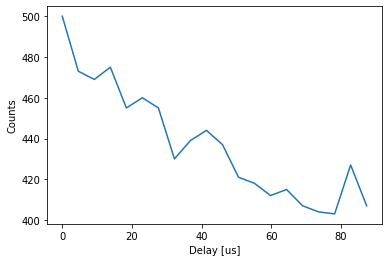

In [76]:
# and plot the result

dt = 0.23
dts = np.arange(0, 400000, 20000)

tpts = dt * dts
plt.plot(tpts / 1e3, np.asarray(data))
plt.xlabel("Delay [us]")
plt.ylabel("Counts")